In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import normalize
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn import metrics

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**Challenge:**   
Apply dimensionality reduction techniques to visualize the observations.  
Apply clustering techniques to group together similar observations.  
In each of the tasks above, try alternative methods and select a best performing one.   Discuss how dimensionality reduction and clustering algorithms enable you to gain insights regarding the data.

I am using a dataset on the 2014 Boston Marathon. This dataset is available here: https://github.com/llimllib/bostonmarathon/tree/master/results/2014  
I want to explore how the different participants cluster into groups based on official race time. I will use dimensionality reduction techniques for visualization purposes. I will also apply k-means and GMM clustering techniques and compare them. Finally, I will further explore gender and age groups. Specifically, I will see how many men/women are in each cluster and how many of each age group (young, middle aged, elder) are in each cluster.

In [0]:
#load data
path = ("https://raw.githubusercontent.com/llimllib/bostonmarathon/master/results/2014/results.csv")
marathon_df = pd.read_csv(path)

**Data Exploration**

In [3]:
#get first 5 rows
marathon_df.head()

,10k,name,division,25k,gender,age,official,bib,genderdiv,ctz,35k,overall,pace,state,30k,5k,half,20k,country,city,40k
0,17.37,"Yamamoto, Hiroyuki",8,47.67,M,47,85.25,W1,8,NaN,71.40,8,3.27,NaN,59.18,8.02,39.72,37.65,JPN,Fukuoka,80.43
1,32.58,"Jeptoo, Rita",1,82.43,F,33,138.95,F1,1,NaN,116.37,21,5.30,NaN,99.33,16.22,69.47,65.83,KEN,Eldoret,132.10
2,16.62,"Van Dyk, Ernst F.",1,45.80,M,41,80.60,W2,1,NaN,67.42,1,3.08,NaN,56.45,7.75,38.03,36.10,RSA,Paarl,76.10
3,32.57,"Dibaba, Mare",3,82.43,F,24,140.58,F2,3,NaN,116.37,27,5.37,NaN,99.33,16.20,69.47,65.83,ETH,Shoa,132.95
4,17.12,"Hokinoue, Kota",2,46.37,M,40,81.23,W3,2,NaN,67.83,2,3.10,NaN,57.03,8.02,38.60,36.58,JPN,Nogata Fukuoka,76.72


In [4]:
#get descriptive stats for numeric variables
marathon_df.describe()

,division,age,official,genderdiv,overall,pace
count,31984.000000,31984.000000,31984.000000,31984.000000,31984.000000,31984.000000
mean,1932.563032,42.407079,242.997314,8051.044741,15939.587825,9.275658
std,1715.228694,11.316496,52.300431,4754.005626,9232.978224,1.992486
min,1.000000,18.000000,80.600000,1.000000,1.000000,3.080000
25%,610.000000,33.000000,205.527500,3972.000000,7943.750000,7.850000
50%,1425.000000,42.000000,232.370000,7970.000000,15939.500000,8.870000
75%,2611.000000,50.000000,273.235000,11968.000000,23935.250000,10.430000
max,6979.000000,81.000000,538.880000,17575.000000,31931.000000,20.570000


In [5]:
#data types
marathon_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31984 entries, 0 to 31983
Data columns (total 21 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   10k        31984 non-null  object 
 1   name       31984 non-null  object 
 2   division   31984 non-null  int64  
 3   25k        31984 non-null  object 
 4   gender     31984 non-null  object 
 5   age        31984 non-null  int64  
 6   official   31984 non-null  float64
 7   bib        31984 non-null  object 
 8   genderdiv  31984 non-null  int64  
 9   ctz        1244 non-null   object 
 10  35k        31984 non-null  object 
 11  overall    31984 non-null  int64  
 12  pace       31984 non-null  float64
 13  state      29408 non-null  object 
 14  30k        31984 non-null  object 
 15  5k         31984 non-null  object 
 16  half       31984 non-null  object 
 17  20k        31984 non-null  object 
 18  country    31984 non-null  object 
 19  city       31983 non-null  object 
 20  40k   

Several of the variables that should be integers are actually objects. I will fix this issue now.

In [0]:
#convert strings to numeric (10k etc)

marathon_df['40k'] = pd.to_numeric(marathon_df['40k'], errors='coerce')
marathon_df['20k'] = pd.to_numeric(marathon_df['20k'], errors='coerce')
marathon_df['half'] = pd.to_numeric(marathon_df['half'], errors='coerce')
marathon_df['5k'] = pd.to_numeric(marathon_df['5k'], errors='coerce')
marathon_df['30k'] = pd.to_numeric(marathon_df['30k'], errors='coerce')
marathon_df['35k'] = pd.to_numeric(marathon_df['35k'], errors='coerce')
marathon_df['25k'] = pd.to_numeric(marathon_df['25k'], errors='coerce')
marathon_df['10k'] = pd.to_numeric(marathon_df['10k'], errors='coerce')

In [7]:
#check missing values
marathon_df.isnull().sum()*100/marathon_df.isnull().count()

10k           0.156328
name          0.000000
division      0.000000
25k           0.675338
gender        0.000000
age           0.000000
official      0.000000
bib           0.000000
genderdiv     0.000000
ctz          96.110555
35k           0.106303
overall       0.000000
pace          0.000000
state         8.054027
30k           0.125063
5k            0.162581
half          0.225113
20k           0.159455
country       0.000000
city          0.003127
40k           0.121936
dtype: float64

In [0]:
#K means and UMAP require numeric data. I will drop these because they are not needed
marathon_df.drop(('ctz'), axis =1, inplace=True)
marathon_df.drop(('name'), axis =1, inplace=True)
marathon_df.drop(('bib'), axis=1, inplace=True)
#drop state due to missing values
marathon_df.drop(('state'), axis = 1, inplace=True)

In [9]:
#convert, drop missing
np.nan_to_num(marathon_df)
marathon_df.dropna(inplace=True)
marathon_df.shape

(31648, 17)

In [10]:
marathon_df.isnull().sum()

10k          0
division     0
25k          0
gender       0
age          0
official     0
genderdiv    0
35k          0
overall      0
pace         0
30k          0
5k           0
half         0
20k          0
country      0
city         0
40k          0
dtype: int64

In [0]:
#create categories for age groups 
bins= [18,40, 60, 81]
labels = ['Young','Middle Aged','Elder']
marathon_df['AgeGroup'] = pd.cut(marathon_df['age'], bins=bins, labels=labels, include_lowest = True)



***Dimensionality Reduction (for Visualization Purposes): t_SNE and PCA*** 

In [0]:
#define X and y (target feature is official for official race time)
X = marathon_df.drop(['overall'], axis = 1).copy()
y = marathon_df['overall']
#convert string variables to categorical
list_to_categorical = ['gender', 'country', 'city', 'AgeGroup']
for n in list_to_categorical:
    
    X[n] = pd.Categorical(X[n])
    X[n] = X[n].cat.codes



**t-SNE:**

In [13]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 31648 samples in 0.083s...
[t-SNE] Computed neighbors for 31648 samples in 2.012s...
[t-SNE] Computed conditional probabilities for sample 1000 / 31648
[t-SNE] Computed conditional probabilities for sample 2000 / 31648
[t-SNE] Computed conditional probabilities for sample 3000 / 31648
[t-SNE] Computed conditional probabilities for sample 4000 / 31648
[t-SNE] Computed conditional probabilities for sample 5000 / 31648
[t-SNE] Computed conditional probabilities for sample 6000 / 31648
[t-SNE] Computed conditional probabilities for sample 7000 / 31648
[t-SNE] Computed conditional probabilities for sample 8000 / 31648
[t-SNE] Computed conditional probabilities for sample 9000 / 31648
[t-SNE] Computed conditional probabilities for sample 10000 / 31648
[t-SNE] Computed conditional probabilities for sample 11000 / 31648
[t-SNE] Computed conditional probabilities for sample 12000 / 31648
[t-SNE] Computed conditional probabilities for sa

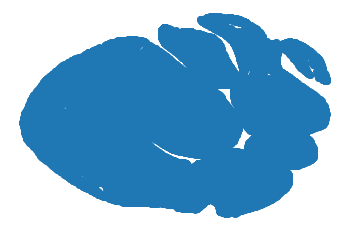

In [14]:
#plot t-SNE 
plt.scatter(tsne_results[:, 0], tsne_results[:, 1])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

Visualizing the data in two dimensions using t-SNE is helpful. The above graphic illustrates that there are several clusters. It is difficult to decipher the exact number of clusters, but it looks like there are 4 or 5 clusters. 

**PCA with 2 components (for 2D visualization)**

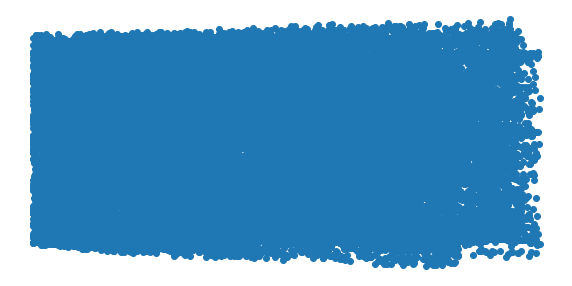

In [15]:
# Use 2 components for two dimensions
pca = PCA(n_components=2)

pca_components = pca.fit_transform(X)

plt.figure(figsize=(10,5))
plt.scatter(pca_components[:, 0], pca_components[:, 1])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

As the above graphic shows, PCA is not very helpful as a visualization technique. While PCA is great for reducing complexity, it does not stack up well against t-SNE in terms of helping us visualize the different clusters in the data.

**K Means**

In [0]:
# K mean is sensitive to the scale of data, so we standarize:
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

Since I do not know the true clustering, I will run k-means with 2-6 clusters and compare the solutions. 

In [0]:
#fit k means and get predictions (2-6 cluster solutions)
pred_2 = KMeans(n_clusters=2, random_state=123).fit_predict(X_std)
pred_3 = KMeans(n_clusters=3, random_state=123).fit_predict(X_std)
pred_4 = KMeans(n_clusters=4, random_state=123).fit_predict(X_std)
pred_5 = KMeans(n_clusters=5, random_state=123).fit_predict(X_std)
pred_6 = KMeans(n_clusters=6, random_state=123).fit_predict(X_std)

In [18]:
#get silhouette scores for each
print("Silhouette score for two cluster k-means: {}".format(
    metrics.silhouette_score(X_std, pred_2, metric='euclidean')))
print("Silhouette score for three cluster k-means: {}".format(
    metrics.silhouette_score(X_std, pred_3, metric='euclidean')))
print("Silhouette score for four cluster k-means: {}".format(
    metrics.silhouette_score(X_std, pred_4, metric='euclidean')))
print("Silhouette score for five cluster k-means: {}".format(
    metrics.silhouette_score(X_std, pred_5, 'euclidean')))
print("Silhouette score for six cluster k-means: {}".format(
    metrics.silhouette_score(X_std, pred_6, 'euclidean')))

Silhouette score for two cluster k-means: 0.3709450080199346
Silhouette score for three cluster k-means: 0.2483384650246784
Silhouette score for four cluster k-means: 0.23849038122911373
Silhouette score for five cluster k-means: 0.21990264564332737
Silhouette score for six cluster k-means: 0.21876429607139514


The silhouette score is highest for the 2 cluster solution. However, for the last part of the analysis (when I compare men/women and the different age groups), I will use the 4 cluster solution. This is because it is difficult to perform an analysis with only 2 clusters. Since the silhouette scores for the 3 and 4 cluster solutions are so similar, I will choose the 4 cluster solution.

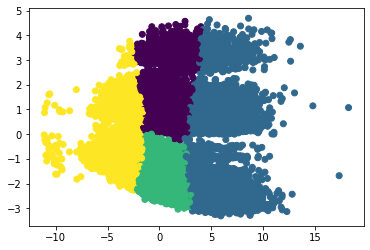

In [21]:
#visualize the k-means 4 cluster solution using 2 PCA components

X_pca = PCA(2).fit_transform(X_std)

y_pred = KMeans(n_clusters=4, random_state=123).fit_predict(X_std)

# Plot the solution
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred)
plt.show()


**GMM Clustering**

In [22]:
# Defining the agglomerative clustering for 2 clusters
gmm_cluster2 = GaussianMixture(n_components=2, random_state=123)

# Fit model
clusters2 = gmm_cluster2.fit_predict(X_std)
#get silhouette score 2 cluster solution
print("Silhouette score for GMM 2 cluster solution: {}".format(
    metrics.silhouette_score(X_std, clusters2, metric='euclidean')))

# Defining the agglomerative clustering for 3 clusters
gmm_cluster3 = GaussianMixture(n_components=3, random_state=123)

# Fit model
clusters3 = gmm_cluster3.fit_predict(X_std)
#get silhouette score 3 cluster solution
print("Silhouette score for GMM 3 cluster solution: {}".format(
    metrics.silhouette_score(X_std, clusters3, metric='euclidean')))

# Defining the agglomerative clustering for 4 clusters
gmm_cluster4 = GaussianMixture(n_components=4, random_state=123)

# Fit model
clusters4 = gmm_cluster4.fit_predict(X_std)
#get silhouette score 4 cluster solution
print("Silhouette score for  for GMM 4 cluster solution: {}".format(
    metrics.silhouette_score(X_std, clusters4, metric='euclidean')))

# Defining the agglomerative clustering for 5 clusters
gmm_cluster5 = GaussianMixture(n_components=5, random_state=123)

# Fit model
clusters5 = gmm_cluster5.fit_predict(X_std)
#get silhouette score 5 cluster solution
print("Silhouette score for GMM 5 cluster solution: {}".format(
    metrics.silhouette_score(X_std, clusters5, metric='euclidean')))

# Defining the agglomerative clustering for 6 clusters
gmm_cluster6 = GaussianMixture(n_components=6, random_state=123)

# Fit model
clusters6 = gmm_cluster6.fit_predict(X_std)
#get silhouette score 6 cluster solution
print("Silhouette score for GMM 6 cluster solution: {}".format(
    metrics.silhouette_score(X_std, clusters6, metric='euclidean')))


Silhouette score for GMM 2 cluster solution: 0.2762941846761903
Silhouette score for GMM 3 cluster solution: 0.12889046246480151
Silhouette score for  for GMM 4 cluster solution: 0.11377245404915237
Silhouette score for GMM 5 cluster solution: 0.07619926287989609
Silhouette score for GMM 6 cluster solution: 0.08684955331296487


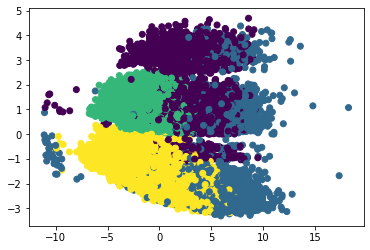

In [23]:
# Plot the GMM 4 cluster solution.
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters4)
plt.show()


Comparing k-means and GMM, k-means performed better. For every number of cluster, the silhouette scores were higher for the k-means solution than for the GMM solution. This tells me that k-means produced better, denser clusters for this dataset. The two plots for the 4 cluster solutions confirm this conclusion. The k means 4 cluster solution plot illustrates more dense clusters in comparison to the GMM 4 cluster solution plot. 

Focusing on the k-means 4 cluster solution, I want to compare clusters. First, in terms of male/female, then in terms of age groups (18-35, 36-55, etc). Females are coded as 0 and males are coded as 1. The age groups are as follows: young (18-39), middle aged (40-59), elder (60+).


In [0]:
#re-run K means with 4 clusters
X_std = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=4, random_state=42)

kmeans.fit(X_std)
#add kmeans_gender predictions to X
X['kmeans_gender'] = kmeans.labels_

In [26]:
#see gender breakdown pre-clustering
X.groupby(['gender']).size()

gender
0    14164
1    17484
dtype: int64

In [25]:
#get gender breakdown per cluster
X.groupby(['kmeans_gender','gender']).size()

kmeans_gender  gender
0              0         2288
               1         8060
1              0         4724
               1         5252
2              0         3174
               1         2802
3              0         3978
               1         1370
dtype: int64

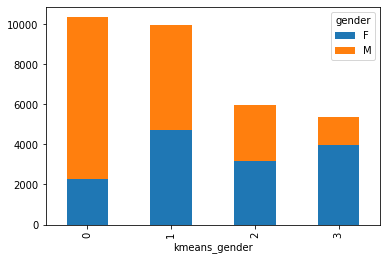

In [29]:
pd.crosstab(X['kmeans_gender'],marathon_df['gender']).plot.bar(stacked=True)

While the number of men and women who raced in the 2014 Boston Marathon was fairly evenly distributed, this is not the case in the 4 cluster solution. As the above bar graph illustrates, there are significantly more men than women in the first cluster but there are many more women than men in the fourth cluster. Since k-means groups based on similarity/distance, I think this graphic and the clustering are illustrating that men (in general) had faster race times. I bet that cluster 1 (or 0 in the plot) is a grouping of those who finished earlier while cluster 4 is a grouping of those who finished later.  

In [0]:
#add kmeans_AgeGroup predictions to X
X['kmeans_AgeGroup'] = kmeans.labels_


In [31]:
#see age group breakdown pre-clustering
X.groupby(['AgeGroup']).size()

AgeGroup
0    13879
1    15855
2     1914
dtype: int64

In [32]:
#count of age groups in each cluster
X.groupby(['kmeans_AgeGroup','AgeGroup']).size()

kmeans_AgeGroup  AgeGroup
0                0           5580
                 1           4735
                 2             33
1                0              5
                 1           8549
                 2           1422
2                0           2946
                 1           2571
                 2            459
3                0           5348
dtype: int64

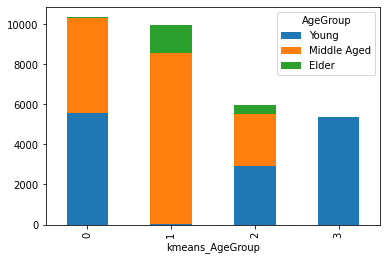

In [33]:
pd.crosstab(X['kmeans_AgeGroup'],marathon_df['AgeGroup']).plot.bar(stacked=True)

While the number of young and middle-aged marathon runners is similar, the number of elder runners is much smaller. The first cluster has a fairly even number of middle aged and young runners but only a small amount of elder runners (33). The second cluster has a very large number of middle aged participants, a small number of elder participants, and a negligible number of elder runners. Of the 4 clusters, the third cluster has the most even distribution of the 3 groups. The fourth cluster is entirely young participants. These clusters are logical to me since k-means clusters based on similarity/distance. The above graphic illustrates to me that participants can be clearly grouped into clusters based on their age group. This is logical as young people (mostly) run faster than those aged 60+ and so on. I would expect that cluster 4 had the fastest race times while cluster 2 had the slowest.

**Summary**

For this particular dataset, k-means produced denser clusters. In general, k-means was useful because I was able to see how the different runners clustered together in meaningful ways, looking closely at gender and age group. In terms of dimensionality reduction for visualization purposes, t-SNE was superior to PCA. This is logical because t-SNE aims to maintain local similarity while PCA focuses on maximizing variance.